鈴木讓「統計的機械学習の数理 with Python 100問」(共立出版)


# 第7章 決定木

## 7.1 回帰の決定木

In [ ]:
! pip install japanize_matplotlib

In [ ]:
!pip uninstall igraph -y
!pip install python-igraph==0.9.6
!pip install cairocffi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import japanize_matplotlib
import scipy
from numpy.random import randn #正規乱数
import igraph

In [2]:
# Anacondaの場合は下記( import japanize_matplotlib はコメントアウト)
import matplotlib
from matplotlib import font_manager
matplotlib.rc("font", family="BIZ UDGothic")

In [3]:
def sq_loss(y):
    if len(y) == 0:
        return 0
    else:
        y_bar = np.mean(y)
        return np.linalg.norm(y - y_bar) ** 2

def branch(x, y, S, rf=0):
    if rf == 0:
        m = x.shape[1]
    if x.shape[0] == 0:
        return [0, 0, 0, 0, 0, 0, 0]
    best_score = np.inf
    for j in range(x.shape[1]):
        for i in S:
            left, right = [], []
            for k in S:
                if x[k, j] < x[i, j]:
                    left.append(k)
                else:
                    right.append(k)
            left_score = f(y[left])
            right_score = f(y[right])
            score = left_score + right_score
            if score < best_score:
                best_score = score
                best_split = (i, j, left, right, left_score, right_score)
    i_1, j_1, left_1, right_1, left_score_1, right_score_1 = best_split
    return [i_1, j_1, left_1, right_1, best_score, left_score_1, right_score_1]

In [4]:
class Stack:
    def __init__(self, parent, set, score):
        self.parent = parent
        self.set = set
        self.score = score

In [5]:
class Node:
    def __init__(self, parent, j, th, set):
        self.parent = parent
        self.j = j
        self.th = th
        self.set = set

In [6]:
def dt(x, y, alpha=0, n_min=1, rf=0):
    if rf == 0:
        m = x.shape[1]
    # 1個の要素からなるstackを構成し、決定木を初期化
    stack = [Stack(0, list(range(x.shape[0])), f(y))]  # 関数fはグローバルに定義される
    nodes = []
    k = -1
    # stackの最後の要素を取り出して、決定木を更新
    while stack:
        popped = stack.pop()
        k += 1
        i, j, left, right, score, left_score, right_score = branch(x, y, popped.set, rf)
        if popped.score - score < alpha or len(popped.set) < n_min or not left or not right:
            nodes.append(Node(popped.parent, -1, 0, popped.set))
        else:
            nodes.append(Node(popped.parent, j, x[i, j], popped.set))
            stack.append(Stack(k, right, right_score))
            stack.append(Stack(k, left, left_score))
    # node.left, node.rightの値を設定
    for h in range(k, -1, -1):
        nodes[h].left = 0
        nodes[h].right = 0
    for h in range(k, 0, -1):
        parent = nodes[h].parent
        if nodes[parent].right == 0:
            nodes[parent].right = h
        else:
            nodes[parent].left = h
    # node.centerの値を計算
    if f == sq_loss:
        get_center_value = np.mean
    else:
        get_center_value = mode_max
    for h in range(k + 1):
        if nodes[h].j == -1:
            nodes[h].center = get_center_value(y[nodes[h].set])
        else:
            nodes[h].center = 0
    return nodes

In [7]:
boston = np.loadtxt("boston.txt", delimiter="\t")
X = boston[:, [0, 2, 4, 5, 6, 7, 9, 10, 11, 12]]
y = boston[:, 13]
f = sq_loss
node = dt(X, y, n_min=50)
len(node)

37

In [8]:
# Edgeの作成
def create_edges(nodes):
    r = len(nodes)
    edges = []
    for h in range(1, r):
        edges.append([nodes[h].parent, h])
    return edges

# tabの作成
def create_tab(nodes):
    r = len(nodes)
    index = [0, 2, 4, 5, 6, 7, 9, 10, 11, 12]
    tab = []
    for h in range(r):
        if nodes[h].j != -1:
            tab.append([h, index[nodes[h].j], nodes[h].th])
    return tab

In [9]:
create_tab(node)

[[0, 5, 6.943],
 [1, 12, 14.43],
 [2, 7, 1.413],
 [4, 5, 6.546],
 [5, 12, 7.6],
 [7, 9, 223.0],
 [9, 5, 6.083],
 [10, 6, 69.5],
 [11, 7, 4.4986],
 [15, 12, 10.15],
 [18, 9, 273.0],
 [21, 0, 7.02259],
 [22, 4, 0.538],
 [24, 12, 19.01],
 [25, 6, 85.7],
 [29, 4, 0.614],
 [31, 12, 19.77],
 [34, 5, 7.454]]

In [10]:
# グラフを描画する関数
def draw_graph(nodes):
    r = len(nodes)
    col = [node.j for node in nodes]
    color_list = ['#ffffff', '#fff8ff', '#fcf9ce', '#d6fada', '#d7ffff', '#d9f2f8', '#fac8be', '#ffebff', '#ffffe0', '#fdf5e6', '#fac8be', '#f8ecd5', '#ee82ee']
    color = [color_list[col[i]] for i in range(r)]
    edges = create_edges(nodes)
    g = igraph.Graph(edges=edges, directed=True)
    layout = g.layout_reingold_tilford(root=[0])
    out = igraph.plot(g, vertex_size=15, layout=layout, bbox=(300, 300), vertex_label=list(range(r)), vertex_color=color)
    return out

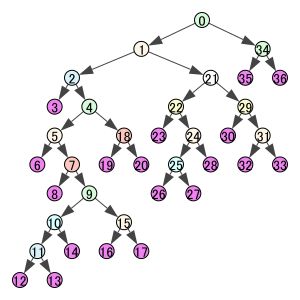

In [11]:
draw_graph(node)

In [12]:
# 特定の値を計算する関数
def value(u, nodes):
    r = 0
    while nodes[r].j != -1:
        if u[nodes[r].j] < nodes[r].th:
            r = nodes[r].left
        else:
            r = nodes[r].right
    return nodes[r].center

In [13]:
# 最初の100サンプルに限定
n = 100
boston = np.loadtxt("boston.txt", delimiter="\t")
X = boston[range(n), :][:, range(13)]
y = boston[range(n), 13]

In [14]:
# Alphaとn_minのシーケンスを用いた検証
alpha_seq = np.arange(0, 1.5, 0.1)
n_min_seq = np.arange(1, 13, 1)
s = int(n / 10)

11.2123
11.169741666666662
11.138088888888886
11.073173611111109
10.98831805555555
10.918474305555554
10.923048228458047
10.894865589569157
10.970726006235825
11.051589873456788
11.008887095679011
10.790952453955654
10.788552453955653
10.975752453955657
10.972330231733434


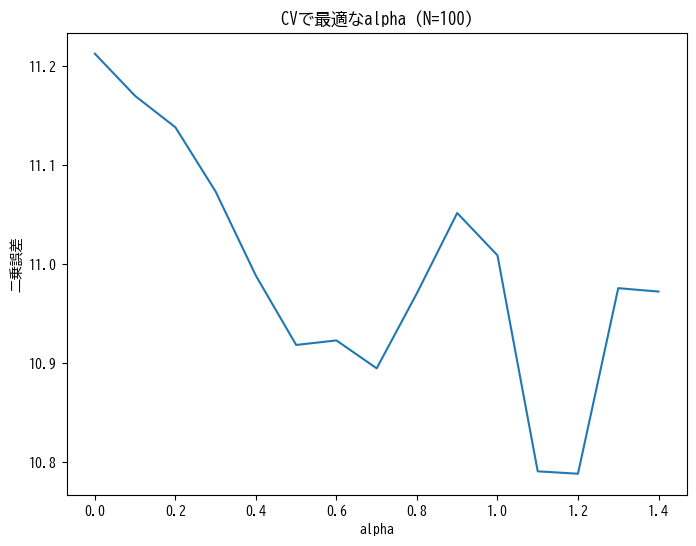

In [15]:
# Alphaの検証
out_alpha = []
for alpha in alpha_seq:
    SS = 0
    for h in range(10):
        test = list(range(h * s, (h + 1) * s))
        train = list(set(range(n)) - set(test))
        nodes = dt(X[train, :], y[train], alpha=alpha)
        for t in test:
            SS += (y[t] - value(X[t, :], nodes)) ** 2
    print(SS / n)
    out_alpha.append(SS / n)

# 結果のプロット
plt.figure(figsize=(8, 6))
plt.plot(alpha_seq, out_alpha)
plt.xlabel('alpha')
plt.ylabel('二乗誤差')
plt.title("CVで最適なalpha (N=100)")
plt.show()

11.2123
11.2123
11.160350000000001
10.779608333333336
10.974831944444444
10.776290444444447
10.778481666666671
10.686344513038552
10.585849200538545
11.914784839238472
12.298008067255603
12.478392363347837


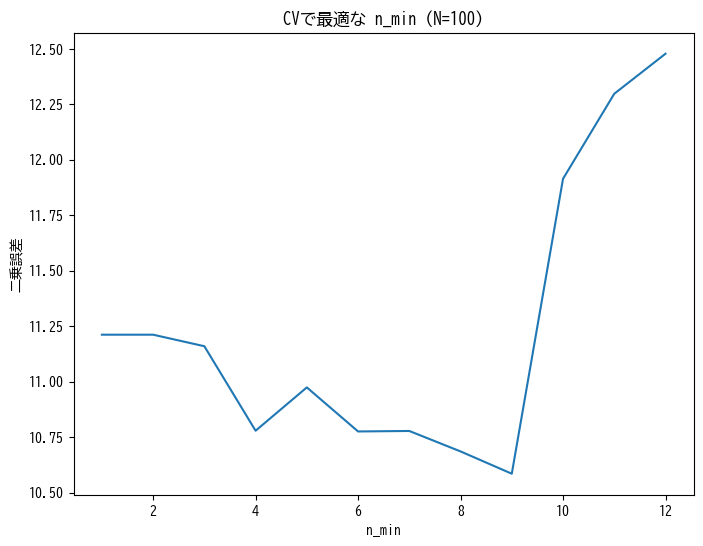

In [16]:
# n_minの検証
out_n_min = []
for n_min in n_min_seq:
    SS = 0
    for h in range(10):
        test = list(range(h * s, (h + 1) * s))
        train = list(set(range(n)) - set(test))
        nodes = dt(X[train, :], y[train], n_min=n_min)
        for t in test:
            SS += (y[t] - value(X[t, :], nodes)) ** 2
    print(SS / n)
    out_n_min.append(SS / n)

# 結果のプロット
plt.figure(figsize=(8, 6))
plt.plot(n_min_seq, out_n_min)
plt.xlabel('n_min')
plt.ylabel('二乗誤差')
plt.title("CVで最適な n_min (N=100)")
plt.show()

## 7.2 分類の決定木

In [17]:
from sklearn.datasets import load_iris

In [18]:
def frequency(y):
    y = list(y)
    return [y.count(i) for i in set(y)]

In [19]:
def mode(y):
    n = len(y)
    if n == 0:
        return 0
    return max(frequency(y))

In [20]:
def mismatch(y):
    return len(y) - mode(y)

In [21]:
def gini(y):
    n = len(y)
    if n == 0:
        return 0
    fr = frequency(y)
    return sum([fr[i] * (n - fr[i]) / n for i in range(len(fr))])

In [22]:
def entropy(y):
    n = len(y)
    if n == 0:
        return 0
    freq = [y.count(i) for i in set(y)]
    return np.sum([-freq[i] * np.log(freq[i] / n) for i in range(len(freq))])

In [23]:
def table_count(m, u, v):
    n = u.shape[0]
    count = np.zeros([m, m])
    for i in range(n):
        count[int(u[i]), int(v[i])] += 1
    return count

In [24]:
from collections import Counter

def mode_max(y):
    if len(y) == 0:
        return -np.inf
    count = Counter(y)
    most_common = count.most_common(1)[0][0]
    return most_common

In [25]:
# 以下の部分は具体的な使用例です。
iris = load_iris()
f = mismatch
n = iris.data.shape[0]
x = iris.data
y = iris.target
n = len(x)
node = dt(x, y, n_min=4)
m = len(node)
u = []
v = []
for h in range(m):
    if node[h].j == -1:
        w = y[node[h].set]
        u.extend([node[h].center] * len(w))
        v.extend(w)
print(table_count(3, np.array(u), np.array(v)))

[[50.  0.  0.]
 [ 0. 48.  0.]
 [ 0.  2. 50.]]


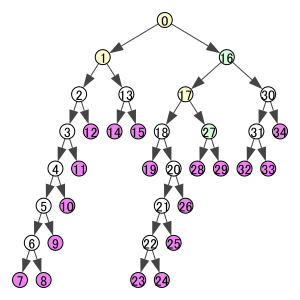

In [26]:
draw_graph(node)

In [27]:
# 以下の部分は具体的な使用例です。
iris = load_iris()
f = mismatch
n = iris.data.shape[0]
x = iris.data
y = iris.target
n = len(x)
node = dt(x, y, n_min=4)
m = len(node)
u = []
v = []
for h in range(m):
    if node[h].j == -1:
        w = y[node[h].set]
        u.extend([node[h].center] * len(w))
        v.extend(w)
print(table_count(3, np.array(u), np.array(v)))

[[50.  0.  0.]
 [ 0. 48.  0.]
 [ 0.  2. 50.]]


In [28]:
iris = load_iris()
f = mismatch  # 関数を変数fに代入
index = np.random.choice(n, n, replace=False)  # 並び替える
X = iris.data[index, :]
y = iris.target[index]
n_min_seq = np.arange(5, 51, 5)  # n_minのシーケンスを生成
s = 15  # テストセットのサイズ

for n_min in n_min_seq:
    ss = 0  # SSを初期化
    for h in range(10):
        test = list(range(h * s, h * s + s))
        train = list(set(range(n)) - set(test))
        node = dt(X[train, :], y[train], n_min=n_min)
        for t in test:
            ss += np.sum(y[t] != value(X[t, :], node))
    print(ss / n)

0.07333333333333333
0.07333333333333333
0.06666666666666667
0.06666666666666667
0.08
0.08
0.08
0.08666666666666667
0.08666666666666667
0.08


## 7.3 バギング

In [29]:
n = 200
p = 5
X = np.random.randn(n, p)
beta = randn(p)
Y = np.array(np.abs(np.dot(X, beta) + randn(n)), dtype=np.int64)
f = mismatch

In [30]:
node_seq = []
for h in range(8):
    index = np.random.choice(n, n, replace=True)  # 並び替える
    x = X[index, :]
    y = Y[index]
    node_seq.append(dt(x, y, n_min=6))

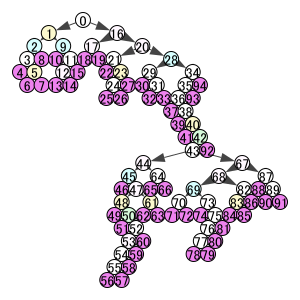

In [31]:
draw_graph(node_seq[0])

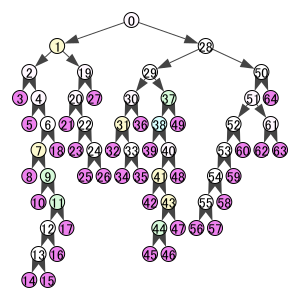

In [32]:
draw_graph(node_seq[1])

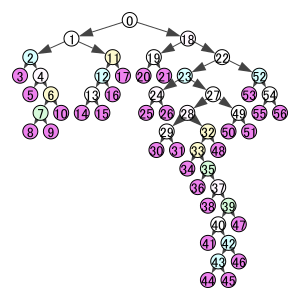

In [33]:
draw_graph(node_seq[2])

## 7.4 ランダムフォレスト

In [34]:
def branch(x, y, S, rf=0):   ##
    if rf == 0:     ##
        T = np.arange(x.shape[1])    ##
    else:   ##
        T = np.random.choice(x.shape[1], rf, replace=False)   ##
    if x.shape[0] == 0:
        return [0, 0, 0, 0, 0, 0, 0]
    best_score = np.inf
    for j in T:    ##
        for i in S:
            left = []
            right = []
            for k in S:
                if x[k, j] < x[i, j]:
                    left.append(k)
                else:
                    right.append(k)
            left_score = f(y[left])
            right_score = f(y[right])
            score = left_score + right_score
            if score < best_score:
                best_score = score
                i_1 = i
                j_1 = j
                left_1 = left
                right_1 = right
                left_score_1 = left_score
                right_score_1 = right_score
    return [i_1, j_1, left_1, right_1, best_score, left_score_1, right_score_1]

In [35]:
def rf(z):
    z = np.array(z, dtype=np.int64)
    zz = []
    for b in range(B):
        u = sum([mode_max(z[range(b+1), i]) == y[i + 100] for i in range(50)])
        zz.append(u)
    return zz

In [36]:
iris = load_iris()
f = mismatch  # 事前に定義された関数
n = iris.data.shape[0]
order = np.random.choice(n, n, replace=False)  # 並び替える
X = iris.data[order, :]
y = iris.target[order]
train = list(range(100))
test = list(range(100, 150))
B = 100

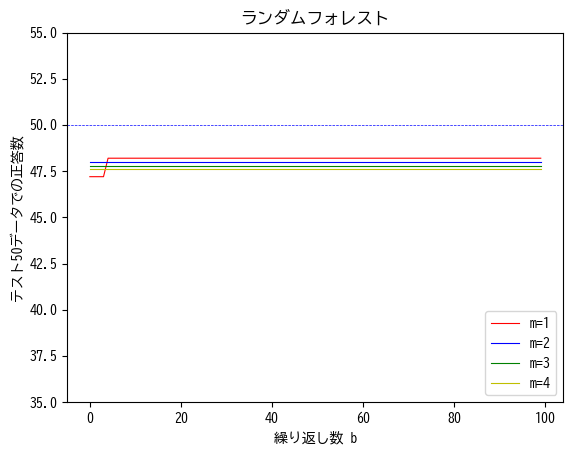

In [37]:
plt.ylim([35, 55])
m_seq = [1, 2, 3, 4]
c_seq = ["r", "b", "g", "y"]
label_seq = ['m=1', 'm=2', 'm=3', 'm=4']
plt.xlabel('繰り返し数 b')
plt.ylabel('テスト50データでの正答数')
plt.title('ランダムフォレスト')
for m, color, label in zip(m_seq, c_seq, label_seq):
    z = np.zeros((B, 50))
    for b in range(B):
        index = np.random.choice(train, 100, replace=True)
        node = dt(X[index, :], y[index], n_min=2, rf=m)
        for i in test:
            z[b, i - 100] = value(X[i, :], node)
    plt.plot(range(B), np.array(rf(z)) - 0.2 * (m - 2), label=label, linewidth=0.8, c=color)
plt.legend(loc='lower right')
plt.axhline(y=50, c="b", linewidth=0.5, linestyle="dashed")
plt.show()

## 7.5 ブーステイング

In [38]:
import lightgbm as lgb

In [39]:
def b_dt(x, y, d):
    n=x.shape[0]
    node=[]
    first=Node(0, -1, 0, np.arange(n))
    first.score=f(y[first.set])
    node.append(first)
    while len(node)<=2*d-1:
        r=len(node)
        gain_max=-np.inf
        for h in range(r):
            if node[h].j==-1:
                i, j, left, right, score, left_score, right_score=branch(x, y, node[h].set)
                gain=node[h].score-score
                if gain >gain_max:
                    gain_max=gain
                    h_max=h
                    i_0=i; j_0=j
                    left_0=left; right_0=right
                    left_score_0=left_score; right_score_0=right_score
        node[h_max].th=x[i_0,j_0]; node[h_max].j=j_0
        next=Node(h_max, -1, 0, left_0)
        next.score=f(y[next.set]); node.append(next)
        next=Node(h_max, -1, 0, right_0)
        next.score=f(y[next.set]); node.append(next)
    r=2*d+1
    for h in range(r):
        node[h].left=0; node[h].right=0
    for h in range(r-1,1,-1):
        pa=node[h].parent
        if node[pa].right==0:
            node[pa].right=h
        else:
            node[pa].left=h
        if node[h].right==0 and node[h].left==0:
            node[h].j=-1
    if f==sq_loss:
        g=np.mean
    else:
        g=mode_max
    for h in range(r):
        if node[h].j==-1:
            node[h].center=g(node[h].set)
# これより下でnode.left, node.rightの値を設定する
    for h in range(r-1,-1,-1):
        node[h].left=0; node[h].right=0;
    for h in range(r-1,0,-1):
        pa=node[h].parent
        if node[pa].right==0:
            node[pa].right=h
        else:
            node[pa].left=h
# これより下で、node.centerの値を計算する
    if f==sq_loss:
        g=np.mean
    else:
        g=mode_max
    for h in range(r):
        if node[h].j==-1:
            node[h].center=g(y[node[h].set])
        else:
            node[h].center=0
    return(node)

In [40]:
boston = np.loadtxt("boston.txt", delimiter="\t")
X = boston[:, range(13)]
y = boston[:, 13]

In [41]:
B = 200
lam = 0.1
train = list(range(200))
test = list(range(200, 300))
f=sq_loss

# ブースティングの木をB個生成
trees_set = []
for d in range(1, 4):
    trees = []
    r = y[train].copy()  # 元の値を変更しないようにコピーを作成
    for b in range(B):
        trees.append(b_dt(X[train, :], r, d))
        for i in train:
            r[i] = r[i] - lam * value(X[i, :], trees[b])
#        print(b)
    trees_set.append(trees)

In [42]:
# テストデータで評価
out_set = []
for d in range(1, 4):
    trees = trees_set[d - 1]
    z = np.zeros((B, 600))
    for i in test:
        z[0, i] = lam * value(X[i, :], trees[0])
        for b in range(1, B):
            for i in test:
                z[b, i] = z[b - 1, i] + lam * value(X[i, :], trees[b])
    out = []
    for b in range(B):
        out.append(sum((y[test] - z[b, test]) ** 2) / len(test))
    out_set.append(out)

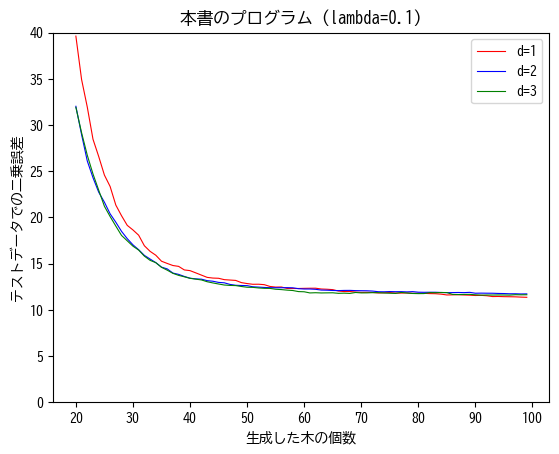

In [43]:
# グラフで表示
plt.ylim([0, 40])
c_seq = ["r", "b", "g"]
label_seq = ['d=1', 'd=2', 'd=3']
plt.xlabel('生成した木の個数')
plt.ylabel('テストデータでの二乗誤差')
plt.title('本書のプログラム (lambda=0.1)')
for d in range(1, 4):
    out = out_set[d - 1]
    u = range(20, 100)
    v = out[20:100]
    plt.plot(u, v, label=label_seq[d - 1], linewidth=0.8, color=c_seq[d - 1])
plt.legend(loc='upper right')
plt.show()

In [44]:
import lightgbm as lgb

In [ ]:
# データセットの準備
lgb_train = lgb.Dataset(X[train, :], y[train])
lgb_eval = lgb.Dataset(X[test, :], y[test], reference=lgb_train)

# パラメータ
B = 5000
nn_seq = list(range(1, 10, 1)) + list(range(10, 91, 10)) + list(range(100, B, 50))
out_set = []

for d in range(1, 4):
    lgbm_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': d + 1,
        'learning_rate': 0.001
    }
    out = []
    for nn in nn_seq:
        model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=nn)
        z = model.predict(X[test, :], num_iteration=model.best_iteration)
        out.append(sum((z - y[test]) ** 2) / 100)
    out_set.append(out)

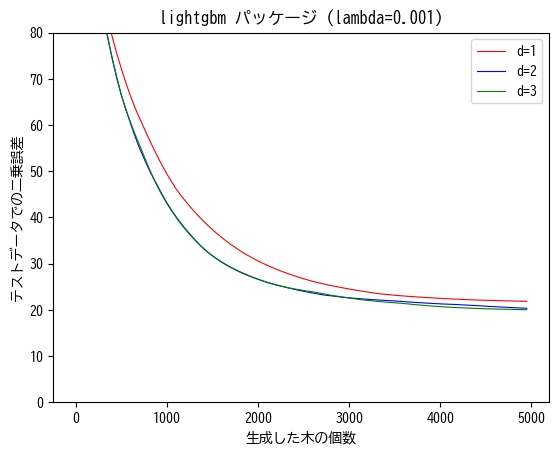

In [46]:
# グラフで表示
plt.ylim([0, 80])
c_seq = ["r", "b", "g"]
label_seq = ['d=1', 'd=2', 'd=3']
plt.xlabel('生成した木の個数')
plt.ylabel('テストデータでの二乗誤差')
plt.title('lightgbm パッケージ (lambda=0.001)')
for d in range(1, 4):
    plt.plot(nn_seq, out_set[d - 1], label=label_seq[d - 1], linewidth=0.8, color=c_seq[d - 1])
plt.legend(loc='upper right')
plt.show()